![Logo 1](img/aitech-logotyp-1.jpg)
<div class="alert alert-block alert-info">
<h1> Widzenie komputerowe </h1>
<h2> 04. <i>Zaawansowane przetwarzanie obrazów i fotografia obliczeniowa</i> [laboratoria]</h2> 
<h3>Andrzej Wójtowicz (2021)</h3>
</div>

![Logo 2](img/aitech-logotyp-2.jpg)

W poniższych materiałach krótko omówimy zagadnienia związane z fotografią obliczeniową, a większą część czasu pozostawimy na realizację zadania dotyczącego wykrywania linii.

Na początku załadujmy niezbędne biblioteki.

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obrazy HDR

Na poprzednich zajęciach widzieliśmy w jaki sposób można poprawić kontrast np. przy pomocy wyrównania histogramu. W niektórych przypadkach jest to wystarczająca operacja pozwalająca uzyskać zadowalający efekt. Niestety, jest też wiele przypadków gdy na potrzebę uchwycenia głównych elementów na zdjęciu obraz musi mieć mniejszą lub większą ekspozycję, co kończy się niedoświetleniem lub prześwietleniem obiektów znajdujących się np. na drugim planie. Zasadniczo w takiej sytuacji chcielibyśmy wyjść poza standardowy ograniczony zakres wartości 0-255 do jakiegoś szerszego zakresu, który z jednej strony pozwoliłby nam uchwycić więcej informacji znajdujących się na scenie, ale z drugiej strony musimy też pamiętać o ponownej konwersji do standardowego zakresu.

Pokażemy tutaj w jaki sposób można wykorzystać technikę [*High dynamic range (HDR) imaging*](https://en.wikipedia.org/wiki/High-dynamic-range_imaging) w OpenCV do uzyskania obrazu o dużej rozpiętości tonalnej. Poniżej mamy kilka zdjęć tego samego obiektu (źródło: Wikipedia, [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)), wykonanych z różnym czasem naświetlania, przez co możemy zauważyć, że część elementów jest niedoświetlona, a część prześwietlona:

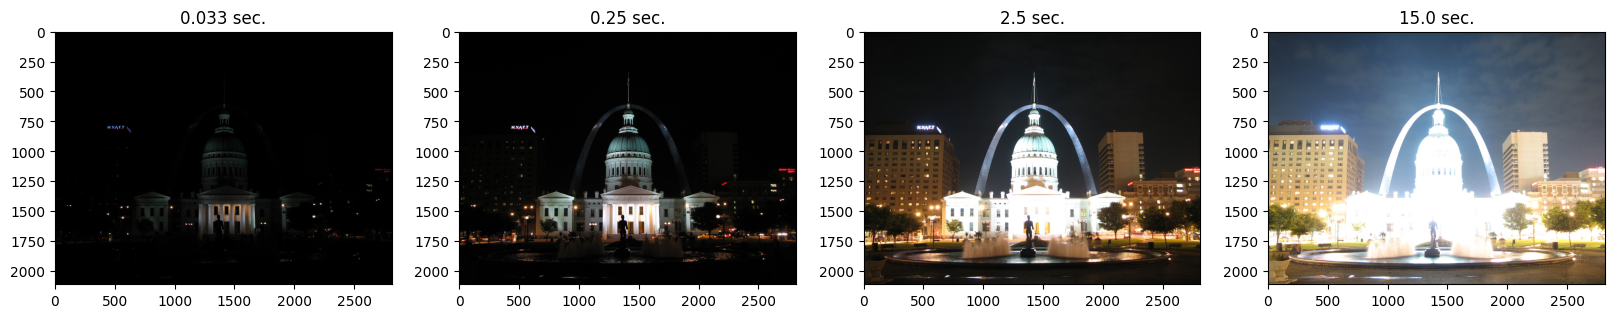

In [2]:
exposure_times = np.array([ 1/30.0, 0.25, 2.5, 15.0 ], dtype=np.float32)
   
f_names = ["st-louis-arch-0.033.jpg", 
           "st-louis-arch-0.25.jpg", 
           "st-louis-arch-2.5.jpg", 
           "st-louis-arch-15.jpg"]

plt.figure(figsize=(20,5))
images = []
for i, f_name in enumerate(f_names):
    image = cv.imread(f"img/{f_name}", cv.IMREAD_COLOR)
    images.append(image)
    
    plt.subplot(141 + i)
    plt.imshow(image[:,:,::-1])
    plt.title(f"{str(round(exposure_times[i], 3))} sec.")

Szczegółowy opis dalszych kroków można znaleźć np. w rozdziale *10.1 Photometric calibration* i *10.2 High dynamic range imaging* książki R. Szeliski *Computer Vision* (2021) - tutaj ograniczymy się do technicznego rozwiązania kolejnych problemów.

Pierwszym problemem, który musimy rozwiązać, jest wyrównanie/dopasowanie obrazów. Nawet jeśli zdjęcie jest robione ze statywu (lub gorzej - z ręki), to po nałożeniu zdjęć na siebie będą widoczne artefakty wynikające z wibracji i przesunięć. W OpenCV możemy to rozwiązać poprzez funkcję [`cv.createAlignMTB()`](https://docs.opencv.org/4.5.3/d7/db6/classcv_1_1AlignMTB.html), która tworzy tzw. bitmapy z progiem mediany (ang. *median threshold bitmaps*), w których zawartość obrazu jest obliczana przez przypisanie wartości 1 pikselom jaśniejszym niż mediana luminancji i 0 w przeciwnym wypadku.

In [3]:
align_mtb = cv.createAlignMTB()
align_mtb.process(images, images)

W dalszych krokach musimy:

* oszacować radiometryczną funkcję odpowiedzi na podstawie wyrównanych obrazów,
* oszacować mapę radiacyjną, wybierając lub mieszając piksele z różnych ekspozycji,
* wykonać mapowanie tonalne wynikowego obrazu HDR z powrotem do postaci umożliwiającej jego normalne wyświetlanie.

In [4]:
calibrate_debevec = cv.createCalibrateDebevec()
response_debevec = calibrate_debevec.process(images, exposure_times)
merge_debevec = cv.createMergeDebevec()
hdr_debevec = merge_debevec.process(images, exposure_times, response_debevec)

Teoretycznie moglibyśmy zapisać teraz wynikowy plik `.hdr` np. przy pomocy `cv.imwrite("hdr_debevec.hdr", hdr_debevec)` i edytować dalej go w programie graficznym. W tym miejscu jednak wykonamy dalszą obróbkę przy pomocy OpenCV, tj. wykonamy mapowanie tonalne. Poniżej mamy zaprezentowane wyniki uzyskane metodą Reinharda i Mantiuka:

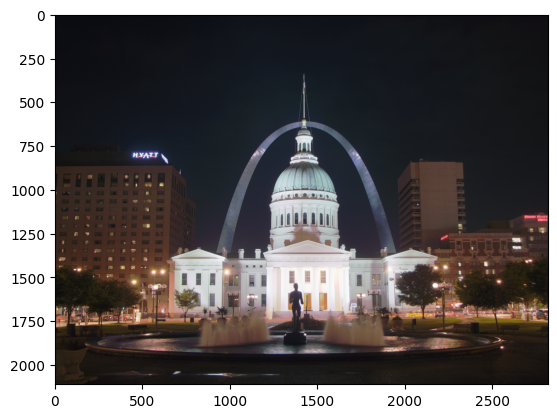

In [5]:
tonemap_rReinhard = cv.createTonemapReinhard(1.5, 0,0,0)
ldr_reinhard = tonemap_rReinhard.process(hdr_debevec)
plt.imshow(ldr_reinhard[:,:,::-1]);

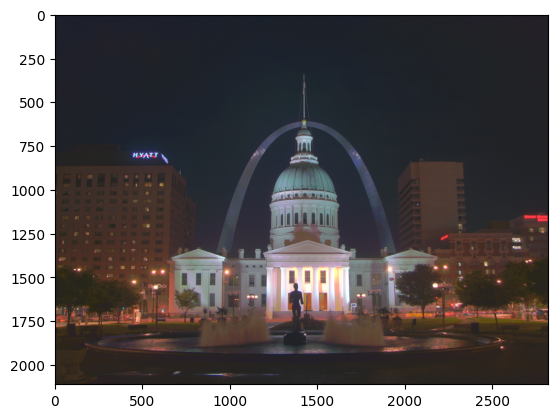

In [6]:
tonemap_mantiuk = cv.createTonemapMantiuk(2.2, 0.85, 1.2)
ldr_mantiuk = tonemap_mantiuk.process(hdr_debevec)
ldr_mantiuk = np.clip(3 * ldr_mantiuk, 0, 1)
plt.imshow(ldr_mantiuk[:,:,::-1]);

# Gładkie klonowanie

Na wcześniejszych zajęciach widzieliśmy, że możemy umieszczać elementy jednego obrazu w drugim obrazie np. poprzez wykorzystanie maski i kanału dotyczącego przezroczystości. Innym ciekawym podejściem jest praca na gradientach obrazu (zamiast na jego intensywności), co może dać równie interesujące, a czasem i bardziej realistyczne wyniki. W tzw. gładkim klonowaniu (ang. *seamless cloning*) intensywność obiektu docelowego będzie różna od intensywności obiektu źródłowego, natomiast gradienty będą podobne. Szczegóły omawianej metody znajdują się w artykule P. Perez et al. (2003) [*Poisson Image Editing*](https://www.irisa.fr/vista/Papers/2003_siggraph_perez.pdf).

Poniżej mamy obraz basenu i kąpiących się w nim ludzi oraz niedźwiedzia, którego chcemy umieścić w basenie:

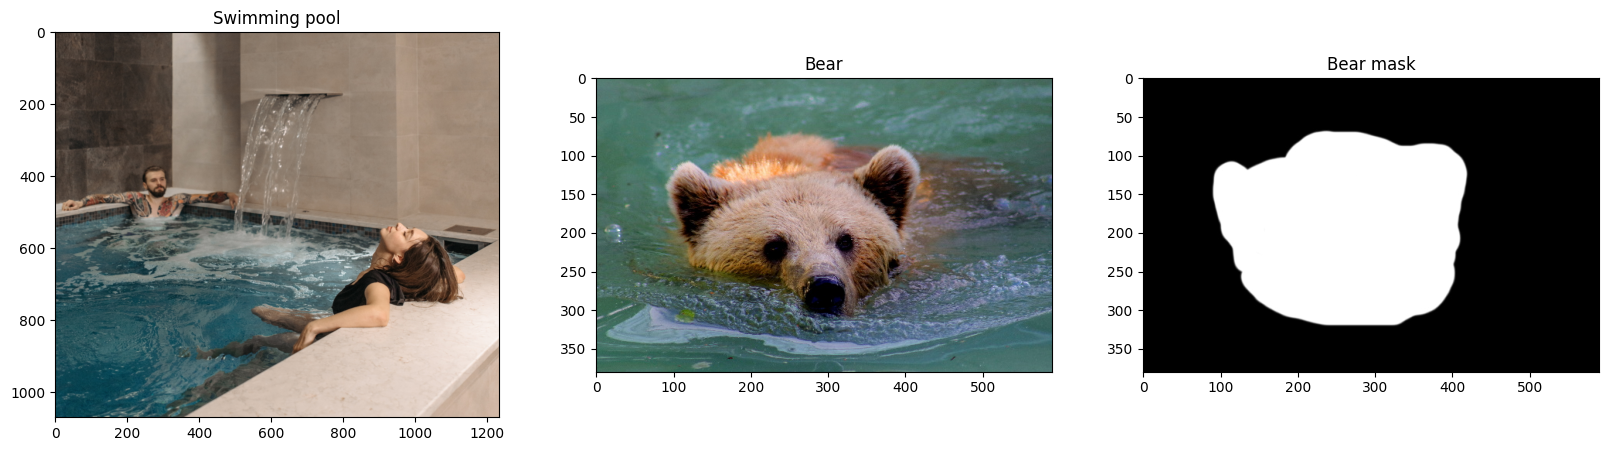

In [7]:
swimmingpool = cv.imread("img/swimmingpool.jpg", cv.IMREAD_COLOR)
bear = cv.imread("img/bear.jpg", cv.IMREAD_COLOR)
bear_mask = cv.imread("img/bear-mask.jpg", cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(swimmingpool[:,:,::-1])
plt.title("Swimming pool")
plt.subplot(132)
plt.imshow(bear[:,:,::-1])
plt.title("Bear")
plt.subplot(133)
plt.imshow(bear_mask[:,:], cmap='gray')
plt.title("Bear mask");

Przy pomocy metody [`cv.seamlessClone()`](https://docs.opencv.org/4.5.3/df/da0/group__photo__clone.html#ga2bf426e4c93a6b1f21705513dfeca49d) wykonujemy gładkie klonowanie:

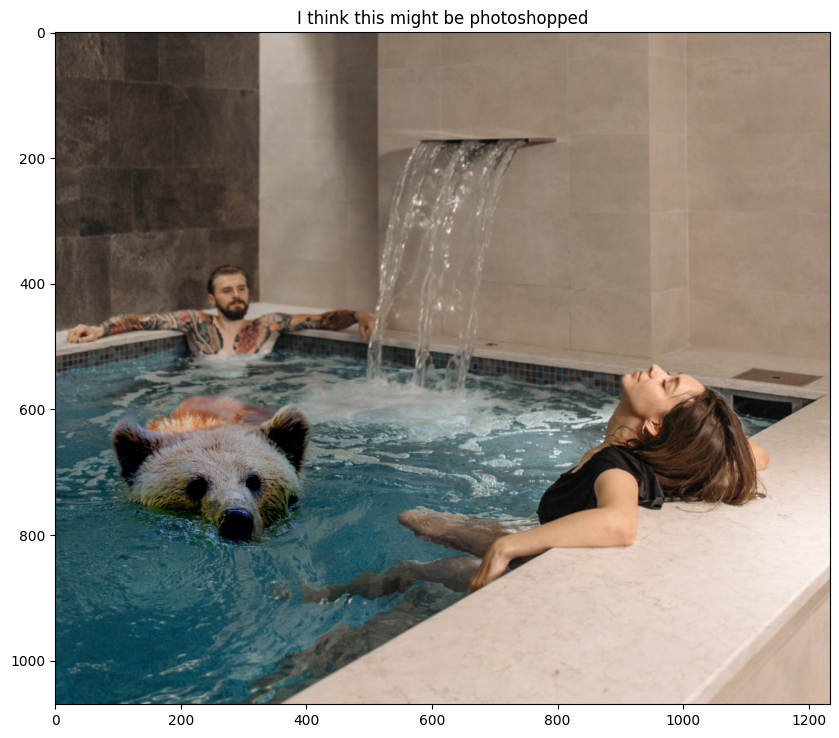

In [8]:
center = (250,700)

swimmingpool_with_bear = cv.seamlessClone(bear, swimmingpool, bear_mask, center, cv.NORMAL_CLONE)

plt.figure(figsize=(10,10))
plt.imshow(swimmingpool_with_bear[:,:,::-1])
plt.title("I think this might be photoshopped");

Spróbujmy teraz umieścić tekst na teksturze:

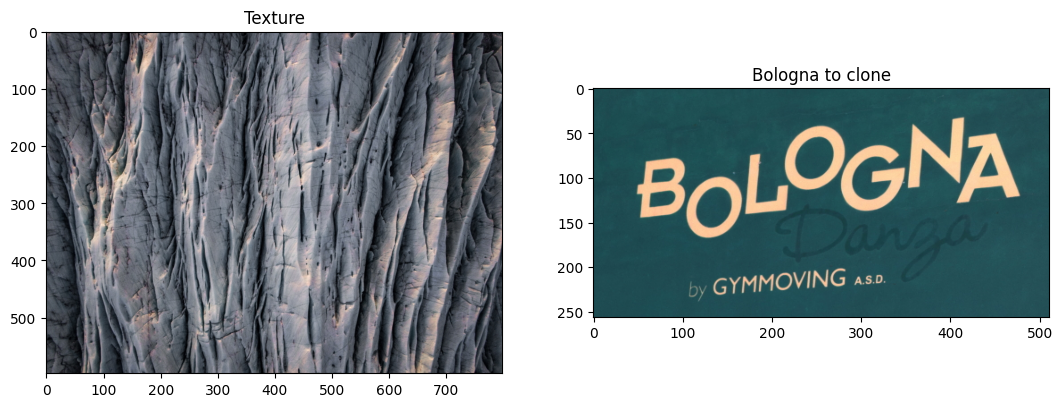

In [9]:
texture = cv.imread("img/texture.jpg", cv.IMREAD_COLOR)
bologna = cv.imread("img/bologna-on-wall.jpg", cv.IMREAD_COLOR)

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(texture[:,:,::-1])
plt.title("Texture")
plt.subplot(132)
plt.imshow(bologna[:,:,::-1])
plt.title("Bologna to clone");

W tym wypadku stworzenie maski może być problematyczne, zatem możemy pójść na skróty i przyjąć, że cały obraz stanowi maskę. Przy takim podejściu zobaczymy jednak, że opcja [`cv.NORMAL_CLONE`](https://docs.opencv.org/4.5.3/df/da0/group__photo__clone.html#gabfc4ba1d1fb873f2b56d34032f86c1d4) spowoduje mocne rozmazanie wokół wklejanej części, stąd też lepszym rozwiązaniem będzie opcja `cv.MIXED_CLONE`, co wynika z kombinacji gradientów z jednego i drugiego obrazu:

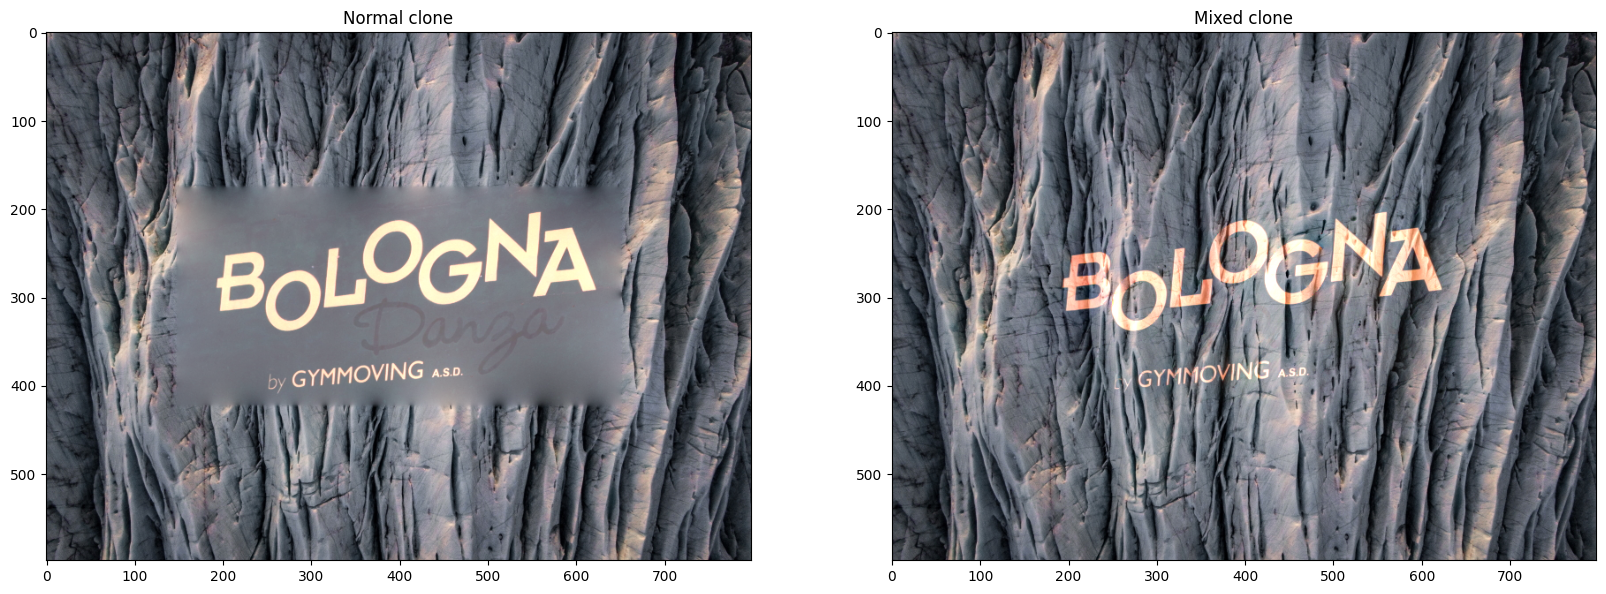

In [10]:
mask = 255 * np.ones(bologna.shape, bologna.dtype)

width, height, channels = texture.shape
center = (height//2, width//2)

normal_clone = cv.seamlessClone(bologna, texture, mask, center, cv.NORMAL_CLONE)
mixed_clone  = cv.seamlessClone(bologna, texture, mask, center, cv.MIXED_CLONE)

plt.figure(figsize=[20,10])
plt.subplot(121)
plt.title("Normal clone")
plt.imshow(normal_clone[:,:,::-1])
plt.subplot(122)
plt.title("Mixed clone")
plt.imshow(mixed_clone[:,:,::-1])
plt.show()

# Usuwanie niechcianych obiektów

Spróbujemy teraz usunąć ze zdjęcia defekty, które często są domeną starych fotografii. Poniżej mamy zdjęcie prezydenta Lincolna z rysą na poziomie włosów; dodatkowo ręcznie ustaliliśmy maskę wskazującą miejsce występowania tej rysy:

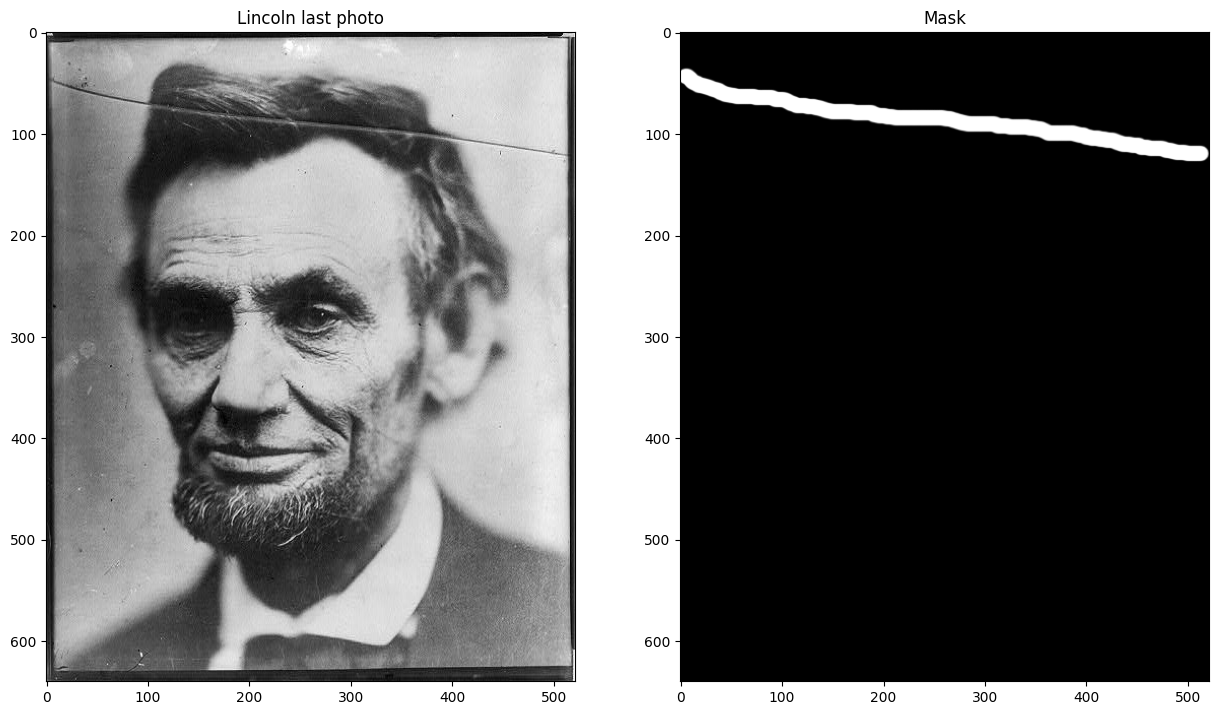

In [11]:
lincoln = cv.imread("img/lincoln.jpg", cv.IMREAD_COLOR)
lincoln_mask = cv.imread("img/lincoln-mask.jpg", cv.IMREAD_GRAYSCALE)

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(lincoln[:,:,::-1])
plt.title("Lincoln last photo")
plt.subplot(122)
plt.imshow(lincoln_mask[:,:], cmap='gray')
plt.title("Mask");

Używając metody [`cv.inpaint()`](https://docs.opencv.org/4.5.3/d7/d8b/group__photo__inpaint.html#gaedd30dfa0214fec4c88138b51d678085) możemy przywrócić wybrany region w obrazie przy pomocy sąsiedztwa zadanego regionu. Metoda `cv.INPAINT_NS` implementuje podejście opisane w M. Bertalmio et al. (2001) [*Navier-Stokes, Fluid Dynamics, and Image and Video Inpainting*](https://www.math.ucla.edu/~bertozzi/papers/cvpr01.pdf), która ogólnie mówiąc ma za zadanie zachować gradienty (np. krawędzie) i rozprowadzać informacje o kolorach na płaskich przestrzeniach. Z kolei `cv.INPAINT_TELEA` implementuje metodę opisaną w A. Telea (2004) [*An image inpainting technique based on the fast marching method*](https://core.ac.uk/download/pdf/148284148.pdf). W obu przypadkach możemy zauważyć oczekiwane wypełnienie na poziomie włosów, aczkolwiek po prawej stronie jest widoczne pewne rozmazanie - być może należałoby poprawić/zawęzić wejściową maskę.

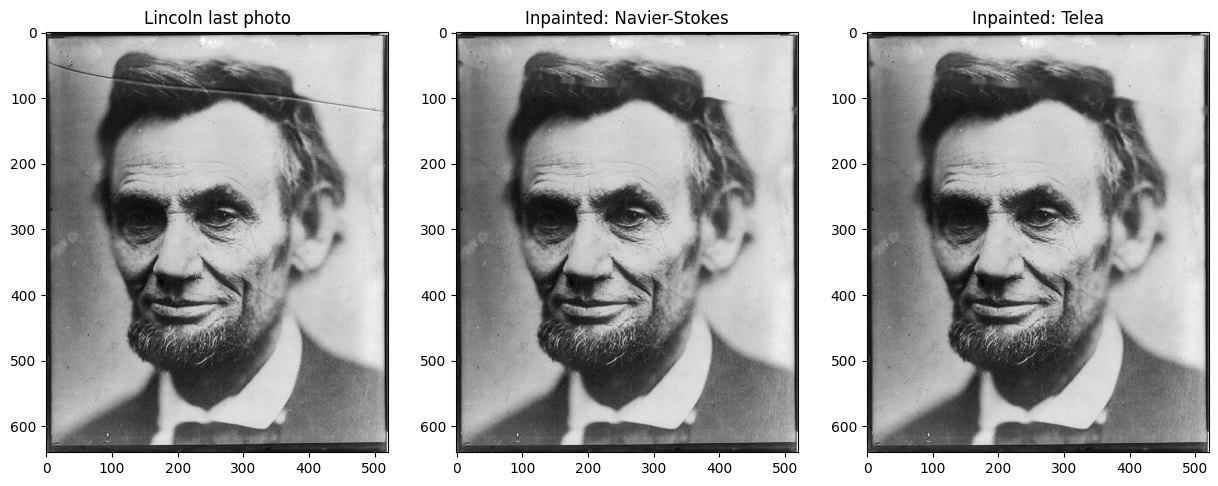

In [12]:
lincoln_inpainted_ns = cv.inpaint(src=lincoln, inpaintMask=lincoln_mask, inpaintRadius=5, flags=cv.INPAINT_NS)
lincoln_inpainted_t  = cv.inpaint(src=lincoln, inpaintMask=lincoln_mask, inpaintRadius=5, flags=cv.INPAINT_TELEA)

plt.figure(figsize=(15,10))
plt.subplot(131)
plt.imshow(lincoln[:,:,::-1])
plt.title("Lincoln last photo")
plt.subplot(132)
plt.imshow(lincoln_inpainted_ns[:,:,::-1])
plt.title("Inpainted: Navier-Stokes")
plt.subplot(133)
plt.imshow(lincoln_inpainted_t[:,:,::-1])
plt.title("Inpainted: Telea");

# Transformata Hougha

## Zadanie 1

W poniższym zadaniu należy przygotować serię operacji, która pozwoli wykryć proste linie na obrazie `img/road-lanes.jpg` przy pomocy [transformaty Hougha](https://docs.opencv.org/4.5.3/d9/db0/tutorial_hough_lines.html) (wym. *hafa*), zaimplementowanej w funkcji [`cv.HoughLines()`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a) lub [`cv.HoughLinesP()`](https://docs.opencv.org/4.5.3/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb). Możemy przyjąć, że przetwarzane zdjęcie jest pojedynczą klatką uzyskaną w kamery znajdującej się na jadącym samochodzie.

Kolejne kroki mogą wyglądać następująco:

1. progowanie obrazu w celu uzyskania pasów na drodze,
2. ograniczenie przetwarzanego obrazu do interesującego nas fragmentu (np. może to być traprez osadzony na dole ekranu zwężający się do środka - góra i boki nas za bardzo nie interesują),
3. wykrycie krawędzi,
4. wykrycie linii transformatą Hougha,
5. ekstrapolacja znalezionych wyżej linii,
6. naniesienie linii na obraz wejściowy.

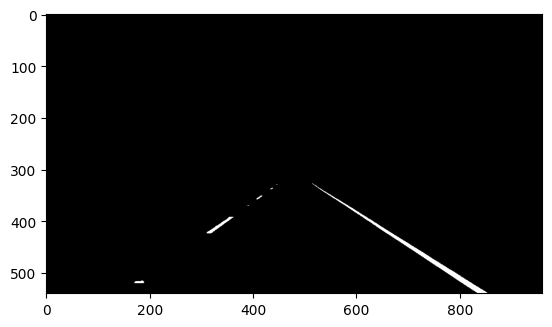

In [53]:
img = cv.imread("img/road-lanes.jpg", cv.IMREAD_GRAYSCALE)
img_orig = cv.imread("img/road-lanes.jpg", cv.IMREAD_COLOR)
_, img_bin = cv.threshold(img, 195, 255, cv.THRESH_BINARY)

#kernel_size = 3
#blur_gray = cv.GaussianBlur(img,(kernel_size, kernel_size),0)
edges = cv.Canny(img_bin, 30, 250)

blank_image = np.zeros((edges.shape[0],edges.shape[1]), np.uint8)

imshape = blank_image.shape

vertices = np.array([[(0,imshape[0]),(450, 320), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
cv.fillPoly(blank_image, vertices, 255)
masked_edges = cv.bitwise_and(img_bin, blank_image)

plt.imshow(masked_edges, cmap='gray')

![Pasy wykryte na drodze](img/road-lanes-detected.png)

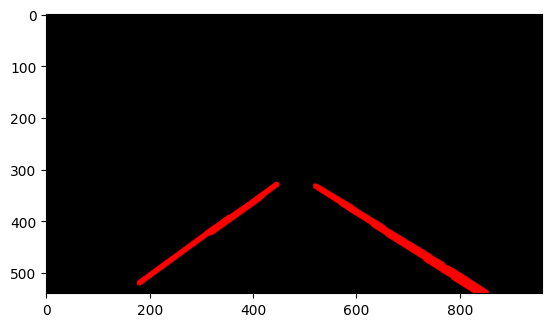

In [61]:
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 40 #minimum number of pixels making up a line
max_line_gap = 125    # maximum gap in pixels between connectable line segments
line_image = np.copy(img_orig)*0 # creating a blank to draw lines on
lines = cv.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),min_line_length, max_line_gap)

for line in lines:
        for x1,y1,x2,y2 in line:
            cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

plt.imshow(line_image, cmap='gray')

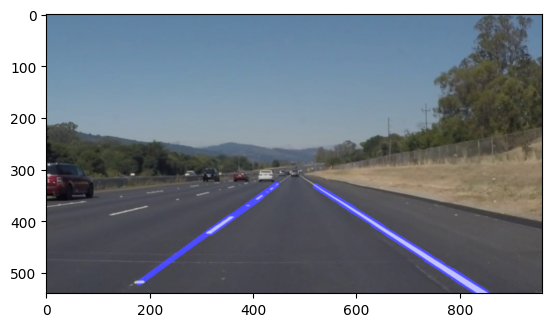

In [64]:
lines_edges = cv.addWeighted(img_orig, 0.8, line_image, 1, 0)
plt.imshow(lines_edges[:,:,::-1])